In [1]:
import os
import random
import time

import numpy as np
import pandas as pd
import scipy as sc
from scipy.io import wavfile
from scipy import signal
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import Compose

from sklearn.metrics import roc_curve, roc_auc_score

import tensorboardX
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
class AudioFrameDataset(Dataset):
    '''Train only'''

    def __init__(self, path_to_data, path_to_split, phase, transform=None, seed=13): 
        self.path_to_data = path_to_data
        voice_set_labels = pd.read_table(path_to_split, sep=' ', names=['path', 'phase'])
        voice_set_labels.replace({'_000': '/0', '.wav$': ''}, inplace=True, regex=True)
        
        # if-else conditions are bullshit there's no need for them because 
        # we need to use another file with predefined pairs for evaluation purposes
        if phase == 1:
            mask = (voice_set_labels.phase == 1) | (voice_set_labels.phase == 3)
            dataset = voice_set_labels[mask].reset_index(drop=True)

        else:
            mask = voice_set_labels['phase'] == phase
            dataset = voice_set_labels[mask].reset_index(drop=True)
            
        self.dataset = dataset['path']
        self.transform = transform
#         self.seed = np.random.RandomState(seed)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        t0 = time.time()
        ### VISUAL INPUT
        video_path = os.path.join(self.path_to_data, 'video', self.dataset[idx] + '.txt')
        frames = pd.read_table(video_path, skiprows=6, usecols=['FRAME '])
        earliest = frames['FRAME '].iloc[0]
        latest = frames['FRAME '].iloc[-1]
        frame_list = np.arange(earliest, latest+1)
        mask = np.where(frame_list % 25 == 0)
        # only 20 per each face-track (see the asterics on the project page)
        # frames_sec = frame_list[mask]
        frames_sec = frame_list[mask][:20]
#         selected_frame = self.seed.choice(frames_sec)
        selected_frame = np.random.choice(frames_sec)
        selected_frame_filename = '{0:07d}.jpg'.format(selected_frame)
        selected_frame_path = os.path.join(self.path_to_data, 'video', 
                                           self.dataset[idx][:-5] + selected_frame_filename)
        frame = cv2.cvtColor(cv2.imread(selected_frame_path), cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_CUBIC)
        
        ### AUDIO INPUT
        segment_len = 3
        # not 1024 as reported in the referenced paper [35] 
        # because it gives 513xN but not 512xN
        FFT_len = 1022
        window = 'hamming'
        audio_path = os.path.join(self.path_to_data, 'audio', self.dataset[idx] + '.wav')
        sample_rate, samples = wavfile.read(audio_path)
        window_width = int(sample_rate * 0.025)
        overlap = int(sample_rate * (0.025 - 0.010))
        upper_bound = len(samples) - segment_len * sample_rate
        start = np.random.randint(0, upper_bound)
        end = start + segment_len * sample_rate
        audio_segment = samples[start:end]
        # Note, it produces 512x298 and I don't know why there is some subtle
        # differences. However, since the model averages second axis it doesn't
        # matter from the computational POV.
        _, _, spectrogram = signal.spectrogram(audio_segment, sample_rate, 
                                               window=window, nfft=FFT_len, 
                                               nperseg=window_width, noverlap=overlap, 
                                               mode='magnitude')
#         spectogram = np.log(spectrogram + 1e-5)
        spectogram = spectrogram.copy()
        assert sample_rate == 16000
        assert len(samples) >= sample_rate * segment_len
        
#         out_f.write(np.array_str(frame) + '\n')
#         out_f.write(np.array_str(spectogram) + '\n')
        
        if self.transform:
            frame = frame.astype(np.float32)
            spectogram = spectogram.astype(np.float32)
            frame, spectogram = self.transform((frame, spectogram))
        
        return frame, spectogram

In [3]:
class AudioFrameDatasetTest(Dataset):
    '''Test only'''

    def __init__(self, path_to_data, path_to_pairs, transform=None): 
        self.path_to_data = path_to_data
        self.transform = transform
        self.dataset = pd.read_table(path_to_pairs, sep=',')[['label', 'voice-path', 'face-path']]
        self.dataset.replace({'_000': '/0'}, inplace=True, regex=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        label, voice_path, face_path = self.dataset.iloc[idx]
        
        ### VISUAL INPUT
        full_face_path = os.path.join(self.path_to_data, 'video', face_path)
        frame = cv2.cvtColor(cv2.imread(full_face_path), cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_CUBIC)
        
        ### AUDIO INPUT
        # not 1024 as reported in the referenced paper [35] 
        # because it gives 513xN but not 512xN
        FFT_len = 1022
        window = 'hamming'
        full_voice_path = os.path.join(self.path_to_data, 'audio', voice_path)

        sample_rate, samples = wavfile.read(full_voice_path)
        window_width = int(sample_rate * 0.025)
        overlap = int(sample_rate * (0.025 - 0.010))
        audio_segment = samples
        _, _, spectrogram = signal.spectrogram(audio_segment, sample_rate, 
                                               window=window, nfft=FFT_len, 
                                               nperseg=window_width, noverlap=overlap, 
                                               mode='magnitude')
        spectogram = np.log(spectrogram + 1e-5)
#         spectogram = spectrogram.copy()
        assert sample_rate == 16000
        
        if self.transform:
            frame = frame.astype(np.float32)
            spectogram = spectogram.astype(np.float32)
            frame, spectogram = self.transform((frame, spectogram))

        return (label, frame, spectogram)

In [4]:
class Normalize(object):
    """Normalizes both face (mean) and voice spectogram (mean-varience)"""
    
    def __call__(self, sample):
        frame, spectogram = sample

        ## FACE (H, W, C)
        # mean normalization for every image (not batch)
        mu = frame.mean(axis=(0, 1))
        frame = frame - mu
        
        ## VOICE (Freq, Time)
        # mean-variance normalization for every spectogram (not batch-wise)
        mu = spectogram.mean(axis=1).reshape(512, 1)
        sigma = spectogram.std(axis=1).reshape(512, 1)
        spectogram = (spectogram - mu) / sigma

        return frame, spectogram

class RandomHorizontalFlip(object):
    '''Horizontally flip the given Image ndarray randomly with a given probability.'''
    
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        frame, spectogram = sample

        if random.random() < self.p:
            return cv2.flip(frame, 1), spectogram
        
        return frame, spectogram

class ColorJittering(object):
    '''Given Image ndarray performs brightness and 
    saturation jittering. It is not mentioned in the paper but I guess 
    the authors used MatConvNet but do not mention any specific augmentation
    parameters. So, I made my wind guess regarding the parameters and implemented
    augmentation in the following fashion as in:
    http://www.vlfeat.org/matconvnet/mfiles/vl_imreadjpeg/
    and the Section 3.5 of the manual
    http://www.vlfeat.org/matconvnet/matconvnet-manual.pdf'''
    
    def __init__(self, brightness=[255/25.5, 255/25.5, 255/25.5], saturation=0.5):
        # brightness
        self.B = np.array(brightness, dtype=np.float32)
        # saturation
        self.S = saturation
    
    def __call__(self, sample):
        frame, spectogram = sample
        
        # brightness
        # gives an error w/o float32 -- normal() returns float64
        w = np.float32(np.random.normal(size=3))
        b = self.B * w
        frame = np.clip(frame + b, 0, 255)
        
        # saturation
        sigma = np.random.uniform(1-self.S, 1+self.S)
        frame = sigma * frame + (1-sigma) / 3 * frame.sum(axis=2, keepdims=True)
        frame = np.clip(frame, 0, 255)
        
        return frame, spectogram
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        frame, spectogram = sample
        F, T = spectogram.shape

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        frame = frame.transpose((2, 0, 1))
        
        # now specs are of size (Freq, Time) 2D but has to be 3D
        spectogram = spectogram.reshape(1, F, T)

        return torch.from_numpy(frame), torch.from_numpy(spectogram)

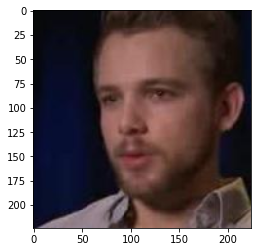

In [5]:
plt.figure()
img = cv2.imread('/home/vladimir/storage8tb/data/voxceleb1/video/Max_Thieriot/tlDioyTt2pc/0000950.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = cv2.flip(img, 1)
plt.imshow(img)
plt.show()

In [6]:
## TRY TO ADD DROPOUT

class FaceSubnet(nn.Module):

    def __init__(self, seed=13):
        super(FaceSubnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        
        self.fc6 = nn.Linear(in_features=256 * 7 * 7, out_features=4096)
        self.fc7 = nn.Linear(in_features=4096, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=256)
        
        self.mpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        B, C, H, W = x.size()
        
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.mpool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.mpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        
        return F.normalize(x)

## TRY TO REMOVE DROPOUT

class VoiceSubnet(nn.Module):

    def __init__(self, seed=13):
        super(VoiceSubnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=7, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        
        self.bn6 = nn.BatchNorm2d(num_features=4096)
        
        self.fc7 = nn.Linear(in_features=4096, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=256)
        
        self.relu = nn.ReLU()
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool5 = nn.MaxPool2d(kernel_size=(5, 3), stride=(3, 2))
        
        # Conv2d with weights of size (H, 1) is identical to FC with H weights
        self.fc6 = nn.Conv2d(in_channels=256, out_channels=4096, kernel_size=(9, 1))
        
    def forward(self, x, DEBUG_I=None):
        B, C, H, W = x.size()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.mpool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.mpool5(x)
        
        _, _, _, W = x.size()
        self.apool6 = nn.AvgPool2d(kernel_size=(1, W))
        
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.apool6(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        
        return F.normalize(x)

<a name='bookmark' />

In [7]:
class CurriculumMining(nn.Module):

    def __init__(self):
        super(CurriculumMining, self).__init__()
        
    def forward(self, positive_pairs, tau):
        faces, voices = positive_pairs
        B, D = faces.size()
        # calc dist 
        # (X - Y) ^ 2 = X^2 + Y^2 - 2XY
        x = (faces**2).sum(dim=1).view(-1, 1) + (voices**2).sum(dim=1) - 2*faces.matmul(voices.t())
        dists = x.sqrt()
        
        sorted_dist, sorted_idx = torch.sort(dists, dim=1, descending=True)
        Dnj = sorted_dist - dists.diag().view(-1, 1)
        idx_threshold = round(tau * (B-1))
        
        # tricky part
        mask = torch.ones_like(sorted_dist)
        mask[:, idx_threshold+1:] = 0
        mask[Dnj <= 0] = 0
        idx_of_sorted_idx = ((mask).sum(dim=1) - 1).abs().long()
        neg_samples_idx = torch.gather(sorted_idx, dim=1, index=idx_of_sorted_idx.view(B, 1))
        neg_samples_idx = neg_samples_idx.view(B)
        negative_voices = voices[neg_samples_idx]
        
        return (faces, negative_voices)

class LearnablePinsNet(nn.Module):

    def __init__(self):
        super(LearnablePinsNet, self).__init__()
        self.face_subnet = FaceSubnet()
        self.voice_subnet = VoiceSubnet()
        self.curr_mining = CurriculumMining()
        
    def forward(self, frames, specs, DEBUG_I, tau=None):
        emb_f = self.face_subnet(frames)
        # GPU MEMORY is okay here
        emb_v = self.voice_subnet(specs, DEBUG_I)
        # GPU MEMORY is not okay here
            
        if self.training:
            positive_pairs = (emb_f, emb_v)
            negative_pairs = self.curr_mining(positive_pairs, tau)

            return positive_pairs, negative_pairs
        
        else:
            return (emb_f, emb_v)

class ContrastiveLoss(nn.Module):

    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        
    def forward(self, positive_pairs, negative_pairs, margin):
        ## POSITIVE PART
        faces, voices = positive_pairs
#         dists_pos = ((faces - voices) ** 2).sum(dim=1).sqrt()
#         pos_part = dists_pos ** 2
        pos_part = ((faces - voices) ** 2).sum(dim=1)
    
        ## NEGATIVE PART
        faces, voices = negative_pairs
        dists_neg = ((faces - voices) ** 2).sum(dim=1).sqrt()
        neg_part = (margin - dists_neg).clamp(0) ** 2
        
        loss4pair = torch.cat([pos_part, neg_part])
        
        ## CALCULATE LOSS
        B, D = faces.size()
        batch_loss = loss4pair.sum() / (2 * B)
    
        return batch_loss

In [8]:
class TauScheduler(object):
    '''
    ## TODO: new doc str
    [trash]:
    "found that it was effective to increase \tau by 10 percent 
    every two epochs, starting from 30% up until 80%, and keeping 
    it constant thereafter"
    --- So, it is increasing up to 10th epoch where becomes 0.8
    '''
    
    def __init__(self, lowest, highest):
        self.current = int(lowest * 100)
        self.highest = int(highest * 100)
        self.epoch_num = 0

    def step(self):
            
        if self.epoch_num % 2 == 0 and self.epoch_num > 0:
#                 self.current += 10
            self.current = int(self.current + self.current * 0.1)
        
        if self.current > self.highest:
            self.current = 80
    
        self.epoch_num += 1
        
    def get_tau(self):
        return self.current / 100
#         return torch.rand(1).item()

In [9]:
LOG_PATH = '/home/vladimir/storage8tb/logs/LearnablePINs/LR_fix_train/'
VALID_LOG_PATH = '/home/vladimir/storage8tb/logs/LearnablePINs/LR_fix_test/'
TXT_LOG_PATH = os.path.join(LOG_PATH, 'debug_log.txt')
DATA_PATH = '/home/vladimir/storage8tb/data/voxceleb1/'
USE_FILTERED = True
TEST_PATH = os.path.join(DATA_PATH, 'testpairs/testpairs')
TEST_RANDOM_SH = os.path.join(TEST_PATH, 'veriflist_test_random_seenheard.txt')
TEST_RANDOM_UU = os.path.join(TEST_PATH, 'veriflist_test_random_unseenunheard.txt')

if USE_FILTERED:
    SPLIT_PATH = os.path.join(DATA_PATH, 'Splits/filtered_voice_set_labels.txt')

else:
    SPLIT_PATH = os.path.join(DATA_PATH, 'Splits/voice_set_labels.txt')

FACE_SUBNET_SNAPSHOT_PATH = os.path.join(LOG_PATH, 'face_subnet_snapshot.txt')
VOICE_SUBNET_SNAPSHOT_PATH = os.path.join(LOG_PATH, 'voice_subnet_snapshot.txt')
PHASE = 1
DEVICES = [0, 1]
B = 85 * len(DEVICES)
# https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/5
NUM_WORKERS = 4 * len(DEVICES)
# NUM_WORKERS = 0
MARGIN = 0.6

In [ ]:
TBoard = tensorboardX.SummaryWriter(log_dir=LOG_PATH)
TBoard2 = tensorboardX.SummaryWriter(log_dir=VALID_LOG_PATH)

transform = Compose([
    Normalize(),
    RandomHorizontalFlip(),
    ColorJittering(),
    ToTensor(),
])

test_transform = Compose([
    Normalize(),
    ToTensor(),
])

train = AudioFrameDataset(DATA_PATH, SPLIT_PATH, phase=PHASE, transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=B, num_workers=NUM_WORKERS)

test = AudioFrameDatasetTest(DATA_PATH, TEST_RANDOM_SH, transform=test_transform)
testloader = torch.utils.data.DataLoader(test, batch_size=1, num_workers=NUM_WORKERS)

net = LearnablePinsNet()

criterion = ContrastiveLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10 ** (-3/25))
tau_scheduler = TauScheduler(lowest=0.3, highest=0.8)
eval_results = {}

device = "cuda"
torch.cuda.set_device(DEVICES[0])
net.to(device);
net = nn.DataParallel(net, DEVICES)

for epoch_num in range(50):
    net.train()
    lr_scheduler.step()
    tau_scheduler.step()

    for iter_num, (frames, log_specs) in tqdm(enumerate(trainloader)):           
        step_num = epoch_num * len(trainloader) + iter_num
        t0 = time.time()

        # transfer inputs to a device
        frames, log_specs = frames.cuda(async=True), log_specs.cuda(async=True)
        frames, log_specs = torch.autograd.Variable(frames), torch.autograd.Variable(log_specs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # 0th, 1st iterations are okay here

        # forward + backward + optimize
        positive_pairs, negative_pairs = net(frames, log_specs, iter_num, tau=tau_scheduler.get_tau())
#             TBoard.add_scalar('Timing/InferenceTime', time.time() - t0, step_num)

        # 0th iteration is okay here, but 1st increases GPU mem on the 0th GPU
#             print('loop', iter_num)
#             if iter_num > 0:
#                 assert True == False

        loss = criterion(positive_pairs, negative_pairs, margin=MARGIN)

        loss.backward()

        optimizer.step()

        TBoard.add_scalar('Train/Loss', loss.item(), step_num)
        TBoard.add_scalar('Train/lr', lr_scheduler.get_lr()[0], step_num)
        TBoard.add_scalar('Train/tau', tau_scheduler.get_tau(), step_num)
        TBoard.add_scalar('emb_mean/face', positive_pairs[0].mean(), step_num)
        TBoard.add_scalar('emb_mean/voice', positive_pairs[1].mean(), step_num)

        if hasattr(net, 'module'):
            TBoard.add_scalar('weights/voice_conv1', net.module.voice_subnet.conv1.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_conv1', net.module.face_subnet.conv1.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_conv5', net.module.voice_subnet.conv5.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_conv5', net.module.face_subnet.conv5.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_fc6', net.module.voice_subnet.fc6.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_fc6', net.module.face_subnet.fc6.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_fc7', net.module.voice_subnet.fc7.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_fc7', net.module.face_subnet.fc7.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_fc8', net.module.voice_subnet.fc8.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_fc8', net.module.face_subnet.fc8.weight.mean(), step_num)

        else:
            TBoard.add_scalar('weights/voice_conv1', net.voice_subnet.conv1.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_conv1', net.face_subnet.conv1.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_conv5', net.voice_subnet.conv5.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_conv5', net.face_subnet.conv5.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_fc6', net.voice_subnet.fc6.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_fc6', net.face_subnet.fc6.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_fc7', net.voice_subnet.fc7.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_fc7', net.face_subnet.fc7.weight.mean(), step_num)
            TBoard.add_scalar('weights/voice_fc8', net.voice_subnet.fc8.weight.mean(), step_num)
            TBoard.add_scalar('weights/face_fc8', net.face_subnet.fc8.weight.mean(), step_num)

    # test
    net.eval()
    results = pd.DataFrame(columns=['predict', 'label'])

    for i, (labels, frames, log_specs) in tqdm(enumerate(testloader)):
        frames, log_specs = frames.cuda(async=True), log_specs.cuda(async=True)
        emb_f, emb_v = net(frames, log_specs, iter_num)
        predict = torch.norm(emb_f - emb_v).item()

        batch_preds_labels = pd.DataFrame([
            pd.Series(predict, name='predict'), 
            pd.Series(labels, name='label')
        ]).transpose()

        results = results.append(batch_preds_labels, ignore_index=True)

    roc_auc = roc_auc_score(results['label'], results['predict'])
    TBoard2.add_scalar('Train/Loss', roc_auc, step_num)
    eval_results[epoch_num] = {'roc_auc': roc_auc, 'table': results}

# when the training is finished
torch.save(net.module.face_subnet.state_dict(), FACE_SUBNET_SNAPSHOT_PATH)
torch.save(net.module.voice_subnet.state_dict(), VOICE_SUBNET_SNAPSHOT_PATH)

148it [08:56,  3.54s/it]

In [ ]:
results.predict.min()

In [ ]:
{0: results}[0]

In [ ]:
roc_auc_score(y_true=np.array([0, 1, 1, 0]), y_score=1-np.array([0.9, 0.2, 0.3, 0.8]))

Go to <a href=#bookmark>my bookmark</a>